In [26]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:
source = pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=10ldL_KjRoANY4x4gMuBOpubHE4_PJgrm')

### используемые функции

In [28]:
def sa_distr(src: pd.Series, N: int, size: int):
  """ Построение распределения выборочной средней 
      :param src - массив значений характеристики (условно, генеральная совокупность)
      :param N - количество выборок для распределения
      :param size - размер каждой выборки
      :return - массив средних
  """
  SA = np.array([src.sample(size).mean() for _ in range(N)])
  return SA


In [29]:
def check_normality(sa, alpha=0.05, title=None, plot=plt):
  """ Проверка распределения на нормальность
      :param sa - массив данных для проверки распределения
      :param plot - объекст отрисовки
  """
  # qq-plot
  st.probplot(sa, dist='norm', plot=plot)
  if title:
    if hasattr(plot, 'set_title'):
      plot.set_title(title)
    elif hasattr(plot, 'title'):
      plot.title(title)

  # Тест Шапиро-Уилка
  _, p = st.shapiro(sa)
  if p < alpha:
    print('Данные распределены НЕ нормально. Пересмотрите значение уровня значимости. Или данные.')
  else:
    print(f'{title + ": " if title else ""}На уровне значимости {alpha} данные распределены нормально.')
  print(f'Расчетный p-value критерия Шапиро-Уилка = {round(p, 3)}')  


In [30]:
def check_hypothesis(src, sa, side='both', alpha=0.05, h0='H0', h1='H1'):
  """ Проверка гипотезы критерием Стьюдента
      :param src - массив проверяемых данных
      :param sa - массив средних выборочных
      :param side - сторона критерия
      :param alpha - уровень значимости
      :param h0 - формулировка нулевой гипотезы
      :param h1 - формулировка альтернативной гипотезы
  """
  # расчетное значение t-критерия
  t = (src.mean() - sa.mean()) * np.sqrt(src.size) / src.std(ddof=1)

  # табличное значение t-критерия
  if side == 'both':
    t0R = st.t.isf(alpha / 2, src.size - 1)
    t0L = st.t.ppf(alpha / 2, src.size - 1)
    passed = t0L < t < t0R
  elif side == 'left':
    t0L = st.t.ppf(alpha, src.size - 1)
    passed = t0L < t
  else:
    t0R = st.t.isf(alpha, src.size - 1)
    passed = t < t0R
    
  if passed:
    print(f'На уровне значимости {alpha} принимаем, что {h0}')
  else:
    print(f'Похоже, что {h1}')


### Преамбула
Молекулы РНК играют непосредственную роль в реализации информации, закодированной в геноме.
После выделения РНК из клеток ткани появляется возможность оценить активность гена с помощью специальных методов.
Одним из наиболее широко используемых является RT-PCR (ПЦР в реальном времени).
Именно этим методом проводится, например, диагностика COVID-19 или обнаружение раковых клеток по маркерам.
Для оценки качества выделенной РНК используется RNA integrity number (RIN) [1].

Если лаборант все сделал правильно, то распределение RIN выделенных образцов должно совпасть с распределением 
генеральной совокупности. Задача в том, чтобы проверить по качеству выделенной РНК, не нарушил ли лаборант протоколов выделения.



### Обзор и обработка данных

Описание данных
> *loc*:       код локализации материала<br>
*type*:      код типа материала<br>
*provider*:  код поставщика материала<br>
*estimate*:  субъективная оценка качества материала, использовалась до внедрения RIN<br>
*RIN*:       RNA integrity number<br>

In [31]:
source.sample(5)

,loc,type,provider,estimate,RIN
805,8,T1,4.0,5.0,NaN
11864,13,T5,4.0,5.0,8.1
8867,2,T1,4.0,4.0,7.3
370,1,T2,4.0,5.0,NaN
4371,2,T2,3.0,5.0,NaN


In [32]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13567 entries, 0 to 13566
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loc       13567 non-null  int64  
 1   type      13557 non-null  object 
 2   provider  13359 non-null  float64
 3   estimate  13567 non-null  float64
 4   RIN       8126 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 530.1+ KB


Как видно из таблиц выше, RIN имеетя только у ~60% записей. Это связано с тем, что до какого-то момента этот способ удостоверения качества РНК не использовался. Данные без RIN придется отбросить, т.к. их восстановление трудозатратно.

In [33]:
data = source[source['RIN'].notna()]

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8126 entries, 4431 to 13566
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   loc       8126 non-null   int64  
 1   type      8116 non-null   object 
 2   provider  8026 non-null   float64
 3   estimate  8126 non-null   float64
 4   RIN       8126 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 380.9+ KB


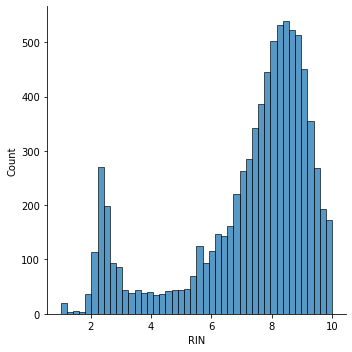

In [35]:
# посмотрим на распределение целевой характеристики
sns.displot(data['RIN'])
plt.show()

Распределение явно НЕ нормальное, значит, надо привести данные к нормальности.

### Построение распределения выборочной средней и проверка на нормальность

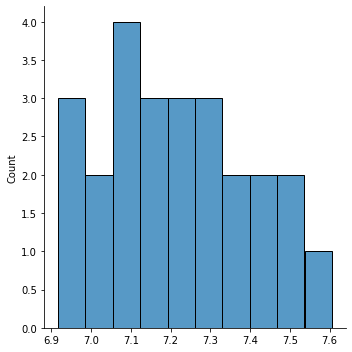

In [36]:
# берем 25 выборок по 120 образцов
SA = sa_distr(data['RIN'], N=25, size=120)
sns.displot(SA, bins=10)
plt.show()

Full data: На уровне значимости 0.05 данные распределены нормально.
Расчетный p-value критерия Шапиро-Уилка = 0.754


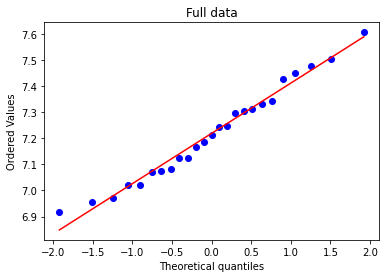

In [37]:
check_normality(SA, alpha=0.05, title='Full data')

### Проверка качества работы лаборанта
Лаборант выделяет определенное количество образцов, данные которых проверяются на соответствие распределению средней выборочной.

In [38]:
# Результаты работы лаборантов
labdata = []
# реальная выборка данных, искусственно заниженная на 30%
# labdata.append(pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=19ubWjVhYuzUWMyN6MXZMnmtWYYqy8iOG')['RIN'])

# реальная выборка данных, искусственно заниженная на 15%
# labdata.append(pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1YsvxKgHPOTiBLGM2N9ypuE3Bsbofz756')['RIN'])

# случайно синтезированные данные
# labdata.append(pd.read_csv('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1rtMVLtoNg5CKeb2fhBTw1pL4KwDVl3X-')['RIN'])

# реальные данные
labdata.append(pd.read_excel('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1uYllIaIsbWAX8Bk9XeFUEF2DdGKVM_gm')['RIN'])
labdata.append(pd.read_excel('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1yC4RHpNE-TjbSDmdOssBqQSvME4iM4gC')['RIN'])
labdata.append(pd.read_excel('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1i_JPekFDpgV8cQX7eyXD986RpV3AHp-D')['RIN'])
labdata.append(pd.read_excel('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1cj28uRdcIOO2xUegYLhsUhr1Ant5E3IG')['RIN'])

labdata = [arr.str.replace('RIN:', '').astype('float') for arr in labdata]

In [39]:
# берем результаты работы лаборанта. Поскольку интересует только ухудшение значения RIN, используем левый критерий 
for ld in labdata:
  check_hypothesis(ld, SA, side='left', alpha=0.05, h0='значения RIN в порядке', h1='значения RIN хуже, чем в среднем')

На уровне значимости 0.05 принимаем, что значения RIN в порядке
На уровне значимости 0.05 принимаем, что значения RIN в порядке
На уровне значимости 0.05 принимаем, что значения RIN в порядке
На уровне значимости 0.05 принимаем, что значения RIN в порядке


во 2ом наборе возможны выявления нарушений.<br>
Если это повторяется систематически на других данных того же лаборанта, то возможно, надо замотивировать его работать качественее.

### Дополнительное исследование
РНК может быть взята не только от живого организма, но и от погибшего. В таком случае ее качество должно быть ниже ввиду быстрой деградации молекулы со временем. Проверим это статистически.

In [40]:
condition = data['type'] != 'A'
alive = data.loc[condition, 'RIN']
dead = data.loc[~condition, 'RIN']

In [41]:
# строим распределения выборочных средних для обеих групп
sa_alive = sa_distr(alive, N=75, size=60)
sa_dead = sa_distr(dead, N=75, size=60)
dead_sample = dead.sample(60)

Alive: На уровне значимости 0.05 данные распределены нормально.
Расчетный p-value критерия Шапиро-Уилка = 0.419
Dead: На уровне значимости 0.05 данные распределены нормально.
Расчетный p-value критерия Шапиро-Уилка = 0.462


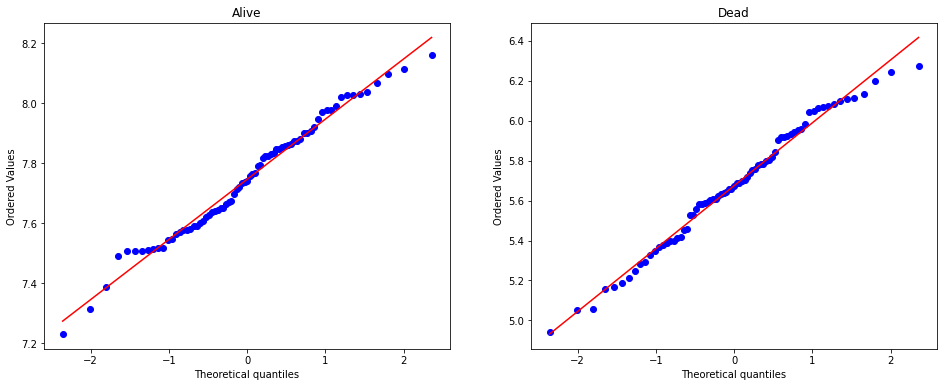

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
check_normality(sa_alive, alpha=0.05, plot=ax[0], title='Alive')
check_normality(sa_dead, alpha=0.05, plot=ax[1], title='Dead')
plt.show()

In [43]:
# Поскольку предполагается, что РНК от погибжего организма менее сохранна, значит среднее значение RIN должно быть меньше.
# Поэтому критерий берем односторонний - левый

a = 0.05
# табличное значение t-критерия
t0L = st.t.ppf(a, dead_sample.size - 1)
# расчетное значение t-критерия
t = (dead_sample.mean() - sa_alive.mean()) * np.sqrt(dead_sample.size) / dead_sample.std(ddof=1)
if t0L < t:
  print(f'На уровне значимости {a} нет статистически значимых различий между РНК от живых и погибших организмов.')
else:
  print(f'Есть статистически значимые различия между РНК от живых и погибших организмов.')

Есть статистически значимые различия между РНК от живых и погибших организмов.
